In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/trainingandtestdata.zip

Archive:  drive/MyDrive/trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [3]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from wordcloud import WordCloud
SEQUENCE_LENGTH = 60
pad_token = '<PAD>'
EMBEDDING_DIM = 300

In [4]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.BuPu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes()
    
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
testData = pd.read_csv('testdata.manual.2009.06.14.csv')
trainData = pd.read_csv('training.1600000.processed.noemoticon.csv' ,  encoding='latin-1')

In [6]:
trainData.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [7]:
testData.head()

,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
0,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
1,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
2,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
3,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
4,4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...


In [8]:
columnNames = ['polarity' , 'id' , 'date' , 'query' , 'user', 'text']
trainData.columns = columnNames
testData.columns = columnNames

In [9]:
testData = testData.loc[testData["polarity"] != 2]

In [10]:
testData.loc[testData['polarity'] == 4, 'polarity'] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [11]:
trainData.loc[trainData['polarity'] == 4, 'polarity'] = 1

In [12]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1599999 non-null  int64 
 1   id        1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   user      1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [13]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358 entries, 0 to 496
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  358 non-null    int64 
 1   id        358 non-null    int64 
 2   date      358 non-null    object
 3   query     358 non-null    object
 4   user      358 non-null    object
 5   text      358 non-null    object
dtypes: int64(2), object(4)
memory usage: 19.6+ KB


In [14]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']


In [15]:
import re
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split(' '):
            if len(word)>1 and word not in stopwordlist:
                word = wordLemm.lemmatize(word)

                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
      
    return processedText

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
preprocess(np.array ( ['i asked @harrison some questions! / and the #results was found in https://google.com :) .'] ))

['asked USER question result found URL EMOJIsmile ']

In [17]:
# !wget http://nlp.stanford.edu/data/glove.42B.300d.zip

In [72]:
!unzip drive/MyDrive/glove.42B.300d.zip

Archive:  drive/MyDrive/glove.42B.300d.zip
replace glove.42B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [17]:
def load_embeddings(filename):
    labels = []
    rows = []
    result = {}
    with open(filename, encoding='utf-8') as infile:
        for i, line in tqdm(enumerate(infile)):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
            result [items[0]] = values
    # arr = np.vstack(rows)
    return result 
    # return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('glove.42B.300d.txt')
# average = np.mean(vectors , axis = 0)

1917494it [03:33, 8996.92it/s]


In [18]:
average =  sum(embeddings.values()) / len(embeddings)

In [19]:
# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"

In [20]:
def decode_sentiment(score):
  SENTIMENT_THRESHOLD = 0.5
  if score <= SENTIMENT_THRESHOLD:
      label = NEGATIVE
  elif score >= SENTIMENT_THRESHOLD:
      label = POSITIVE
  return label

In [21]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score )

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [22]:
# columnNames = ['polarity' , 'id' , 'date' , 'query' , 'user', 'text']
del testData['id'] ,testData['date'] ,  testData['query'] , testData['user'] , trainData ['id'] ,  trainData['date'] , trainData['query'] , trainData['user']

[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

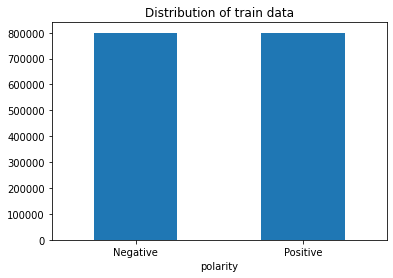

In [23]:
ax = trainData.groupby('polarity').count().plot(kind='bar', title='Distribution of train data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

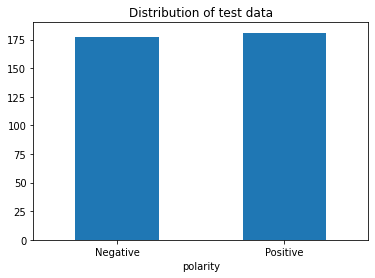

In [148]:
ax = testData.groupby('polarity').count().plot(kind='bar', title='Distribution of test data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [24]:
text, sentiment = list(trainData['text']), list(trainData['polarity'])

In [25]:
test_text, test_sentiment = list(testData['text']), list(testData['polarity'])

In [27]:
del trainData , testData

In [ ]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

In [ ]:
t = time.time()
processed_test_text = preprocess(test_text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

In [ ]:
maxLength = 0
for item in processedtext:
  if len(item.split()) > maxLength:
 
    maxLength = len(item.split())
print(f"maximum sequence length is: {maxLength} " )

In [ ]:
tokenizer = Tokenizer( )
tokenizer.fit_on_texts(processedtext)

In [ ]:
vocab_size = len(tokenizer.word_index)
print("Total words", vocab_size)

In [ ]:
vocabulary =  tokenizer.word_index
print('Found %s unique tokens.' % len(vocabulary))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_validation, Y_train, Y_validation = train_test_split(pad_sequences(tokenizer.texts_to_sequences(processedtext), maxlen=SEQUENCE_LENGTH , padding = 'post'), sentiment ,test_size = 0.33, random_state = 42  )
print(f'Data Split done.')

In [ ]:
x_test = pad_sequences(tokenizer.texts_to_sequences(processed_test_text), maxlen=SEQUENCE_LENGTH , padding = 'post')
y_test = test_sentiment

In [ ]:
# del processedtext , processed_test_text     , sentiment        , text                       

Word-Cloud for Negative tweets.

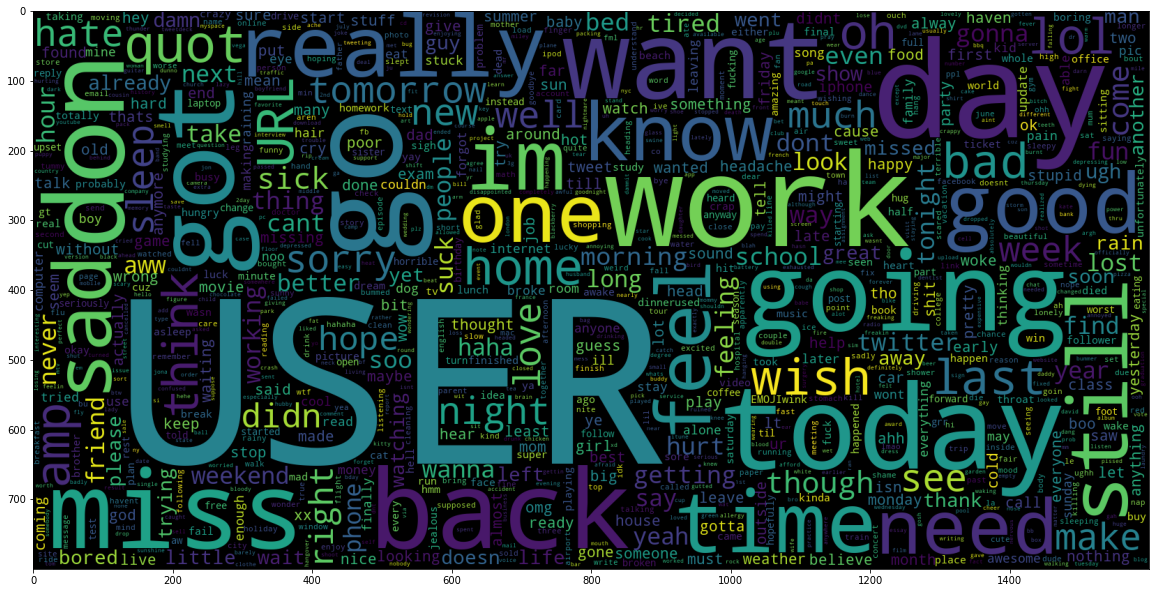

In [92]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Word-Cloud for Positive tweets.


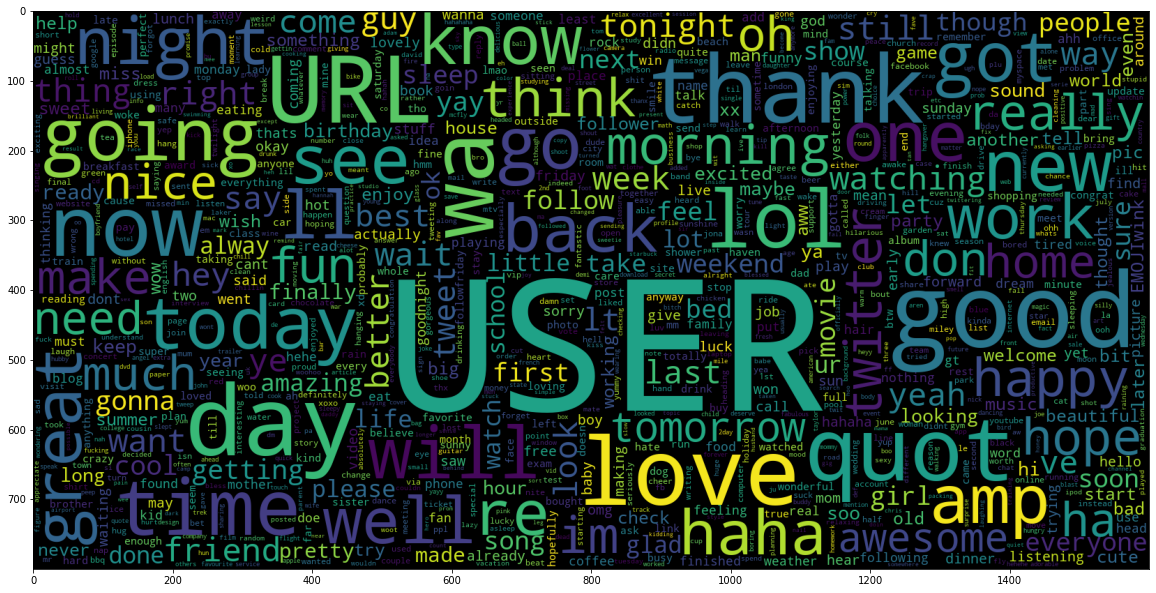

In [ ]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

 ## uni-directional LSTM

In [161]:
embedding_matrix = np.zeros((len(vocabulary)+1 , EMBEDDING_DIM))

In [162]:
for word, idx in vocabulary.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[idx] = embedding_vector
    else:
        embedding_matrix[idx] = average

In [170]:
adamoptimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
bceloss = tf.keras.losses.binary_crossentropy
embedding_layer = Embedding(vocab_size +1,  300 , weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [171]:
model = tf.keras.models.Sequential()
model.add(embedding_layer)
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.LSTM(150 , dropout = 0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [172]:
my_metrics =['accuracy' , 'Precision' , 'Recall'  ]
model.compile( loss = bceloss , optimizer = adamoptimizer , metrics = my_metrics )

In [173]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [174]:
BATCH_SIZE = 1024
EPOCHS = 10

In [175]:
history = model.fit(X_train, np.array(Y_train),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data = (X_validation , np.array(Y_validation)),
                    verbose=1,
                    callbacks=callbacks  )

Epoch 1/10
1047/1047 [==============================] - 163s 154ms/step - loss: 0.5081 - accuracy: 0.7480 - precision: 0.7538 - recall: 0.7355 - val_loss: 0.4523 - val_accuracy: 0.7916 - val_precision: 0.8075 - val_recall: 0.7673 - lr: 0.0010
Epoch 2/10
1047/1047 [==============================] - 160s 153ms/step - loss: 0.4659 - accuracy: 0.7774 - precision: 0.7765 - recall: 0.7781 - val_loss: 0.4315 - val_accuracy: 0.7988 - val_precision: 0.8225 - val_recall: 0.7635 - lr: 0.0010
Epoch 3/10
1047/1047 [==============================] - 160s 153ms/step - loss: 0.4533 - accuracy: 0.7852 - precision: 0.7845 - recall: 0.7858 - val_loss: 0.4247 - val_accuracy: 0.8062 - val_precision: 0.8216 - val_recall: 0.7836 - lr: 0.0010
Epoch 4/10
1047/1047 [==============================] - 160s 153ms/step - loss: 0.4446 - accuracy: 0.7905 - precision: 0.7895 - recall: 0.7915 - val_loss: 0.4205 - val_accuracy: 0.8085 - val_precision: 0.8050 - val_recall: 0.8157 - lr: 0.0010
Epoch 5/10
1047/1047 [======

In [176]:
model.save('unidirectional_lstm.h5')

In [201]:
score = model.evaluate(x_test, np.array(y_test))
print("ACCURACY:",score[1])
print("LOSS:",score[0])
print("PRECISION:",score[2])
print("RECALL:",score[3])

12/12 [==============================] - 0s 9ms/step - loss: 0.3318 - accuracy: 0.8380 - precision: 0.8727 - recall: 0.7956
ACCURACY: 0.8379888534545898
LOSS: 0.33179399371147156
PRECISION: 0.8727272748947144
RECALL: 0.7955800890922546


In [178]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

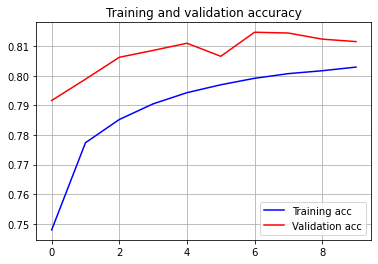

In [179]:
plt.figure()
plt.grid() 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

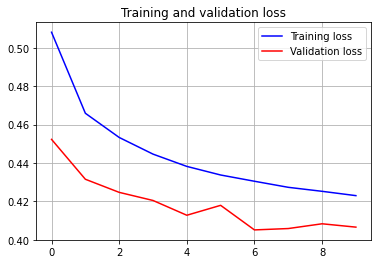

In [180]:
plt.figure()
plt.grid() 

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [187]:
loss , accuracy , precision , recall = model.evaluate(x_test , np.array(y_test))

12/12 [==============================] - 0s 10ms/step - loss: 0.3318 - accuracy: 0.8380 - precision: 0.8727 - recall: 0.7956


In [189]:
print ( 'loss: ' ,  loss , 'accuracy: ' , accuracy , 'precision: ',  precision , 'recall: ',  recall  )

loss:  0.33179399371147156 accuracy:  0.8379888534545898 precision:  0.8727272748947144 recall:  0.7955800890922546


12/12 [==============================] - 1s 7ms/step


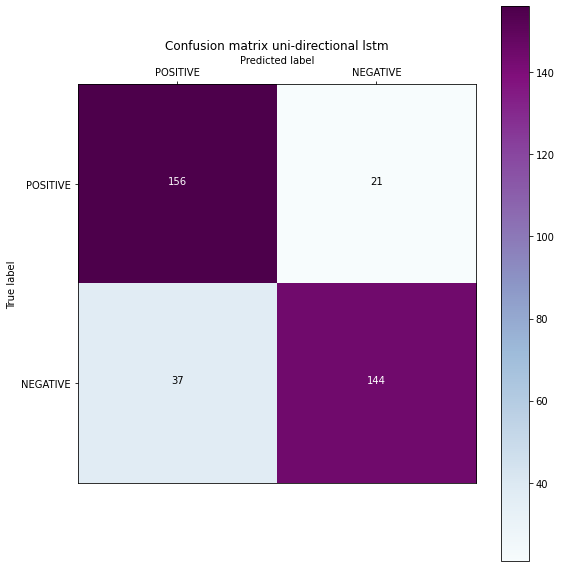

In [181]:
y_pred_1d = []
y_test_1d = y_test
scores = model.predict(x_test, verbose=1)
for score in scores:
  if score > 0.5:
    y_pred_1d.append(1)
  else:
    y_pred_1d.append(0)
cnf_matrix = tf.math.confusion_matrix(y_test_1d, y_pred_1d)
plot_confusion_matrix(np.array(cnf_matrix), classes= [POSITIVE , NEGATIVE ], title="Confusion matrix uni-directional lstm")
plt.show()

In [183]:
c=0
for i in range(len(y_test)):
  if y_pred_1d[i] == y_test_1d[i]:
    c+=1
print(c/len(y_test)*100)

83.79888268156425


## bidirectionalLSTM


In [190]:
adamoptimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
bceloss = tf.keras.losses.binary_crossentropy
embedding_layer = Embedding(vocab_size +1,  300 , weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [191]:
bi_model = tf.keras.models.Sequential()
bi_model.add(embedding_layer)
bi_model.add(tf.keras.layers.Dropout(0.5))
bi_model.add(   tf.keras.layers.Bidirectional (    tf.keras.layers.LSTM(150, dropout=0.2)) )
bi_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [192]:
my_metrics =['accuracy' , 'Precision' , 'Recall'  ]
EPOCHS = 10
BATCH_SIZE = 1024
bi_model.compile( loss = bceloss , optimizer = adamoptimizer , metrics = my_metrics )

In [193]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [194]:
history2 = bi_model.fit(X_train, np.array(Y_train),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data = (X_validation , np.array(Y_validation)),
                    verbose=1,
                    callbacks=callbacks  )

Epoch 1/10
1047/1047 [==============================] - 317s 298ms/step - loss: 0.4987 - accuracy: 0.7537 - precision: 0.7558 - recall: 0.7487 - val_loss: 0.4389 - val_accuracy: 0.7930 - val_precision: 0.8149 - val_recall: 0.7597 - lr: 0.0010
Epoch 2/10
1047/1047 [==============================] - 311s 297ms/step - loss: 0.4600 - accuracy: 0.7801 - precision: 0.7801 - recall: 0.7793 - val_loss: 0.4242 - val_accuracy: 0.8023 - val_precision: 0.7966 - val_recall: 0.8132 - lr: 0.0010
Epoch 3/10
1047/1047 [==============================] - 310s 296ms/step - loss: 0.4471 - accuracy: 0.7885 - precision: 0.7885 - recall: 0.7877 - val_loss: 0.4173 - val_accuracy: 0.8066 - val_precision: 0.8114 - val_recall: 0.8002 - lr: 0.0010
Epoch 4/10
1047/1047 [==============================] - 311s 297ms/step - loss: 0.4391 - accuracy: 0.7930 - precision: 0.7926 - recall: 0.7929 - val_loss: 0.4126 - val_accuracy: 0.8095 - val_precision: 0.8177 - val_recall: 0.7978 - lr: 0.0010
Epoch 5/10
1047/1047 [======

In [195]:
bi_model.save('bidirectional_lstm.h5')

In [196]:
score = bi_model.evaluate(x_test, np.array(y_test))
print("ACCURACY:",score[1])
print("LOSS:",score[0])
print("PRECISION:",score[2])
print("RECALL:",score[3])

12/12 [==============================] - 0s 17ms/step - loss: 0.3412 - accuracy: 0.8268 - precision: 0.8324 - recall: 0.8232
ACCURACY: 0.826815664768219
LOSS: 0.3411807119846344
PRECISION: 0.832402229309082
RECALL: 0.8232043981552124


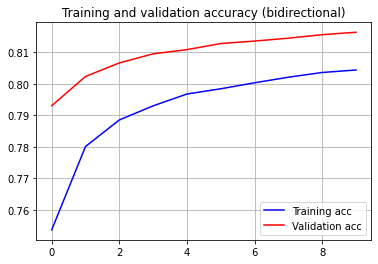

In [202]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
 
epochs = range(len(acc))

plt.figure()

plt.grid() 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (bidirectional)')
plt.legend()
plt.show()


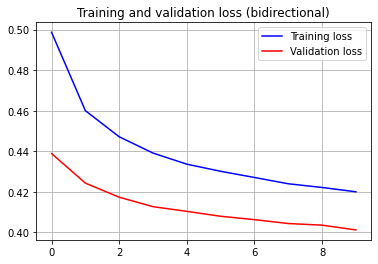

In [203]:
plt.figure()
plt.grid() 

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (bidirectional)')
plt.legend()
plt.show()

12/12 [==============================] - 0s 12ms/step


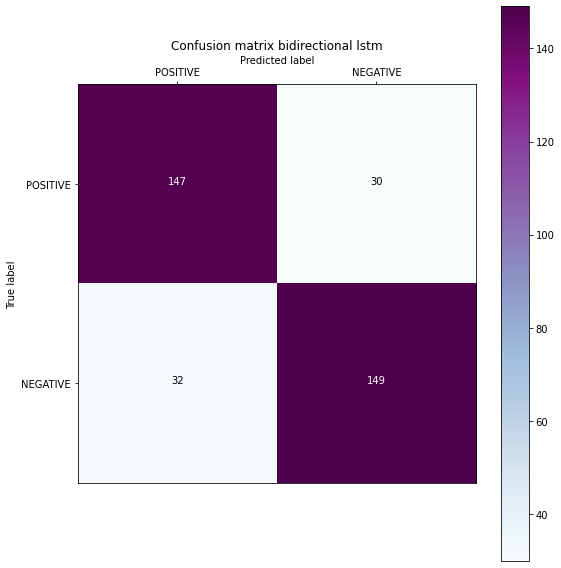

In [206]:
y_pred_2d = []
y_test_2d = y_test
scores = bi_model.predict(x_test, verbose=1).round()
y_pred_2d = scores

cnf_matrix = tf.math.confusion_matrix(y_test_2d, y_pred_2d)
plot_confusion_matrix(np.array(cnf_matrix), classes= [POSITIVE , NEGATIVE ], title="Confusion matrix bidirectional lstm")
plt.show()

In [205]:
c=0
for i in range(len(y_test_2d)):
  if y_pred_2d[i] == y_test_2d[i]:
    c+=1
print(c/len(y_test_2d)*100)

82.68156424581005


##pyramidal LSTM

In [33]:
embedding_matrix = np.zeros((len(vocabulary)+1 , EMBEDDING_DIM))

In [34]:
for word, idx in vocabulary.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[idx] = embedding_vector
    else:
        embedding_matrix[idx] = average

In [35]:
adamoptimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
bceloss = tf.keras.losses.binary_crossentropy

In [36]:
layer1 = {}
def LSTM_unit_1 (xin , i ):
    layer1['unit'+ str(i)] =  tf.keras.layers.LSTM(1, dropout=0.2 , return_sequences= True , name = 'lstm_1_'+ str (i)) (xin)

In [37]:
layer2 = {}
def LSTM_unit_2 (xin , i ):
    layer2['unit'+ str(i)] =  tf.keras.layers.LSTM(1, dropout=0.2 , return_sequences= True , name = 'lstm_2_'+ str (i)) (xin)

In [38]:
layer3 = {}
def LSTM_unit_3 (xin , i ):
    layer3['unit'+ str(i)] =  tf.keras.layers.LSTM(1, dropout=0.2 , return_sequences= True , name = 'lstm_3_'+ str (i)) (xin)

In [39]:

layer4 = {}
def LSTM_unit_4 (xin , i ):
    layer4['unit'+ str(i)] =  tf.keras.layers.LSTM(1, dropout=0.2 , return_sequences= True , name = 'lstm_4_'+ str (i)) (xin)

In [40]:
layer5 = {}
def LSTM_unit_5 (xin , i ):
    layer5['unit'+ str(i)] =  tf.keras.layers.LSTM(1, dropout=0.2 , return_sequences= False , name = 'lstm_5_'+ str (i)) (xin)

In [41]:
inputsss = tf.keras.Input( shape = (  SEQUENCE_LENGTH) )
xin_ = Embedding(vocab_size +1,  300 , weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False) ( inputsss)
xin = tf.keras.layers.Dropout(0.5) (xin_)

for i in range(64):
  LSTM_unit_1(xin , i+1)

In [42]:
layer2_inputs = {}
for i in range(63):
  if i % 2 == 0 :
    layer2_inputs[i/2+1] =  tf.keras.layers.Concatenate(  axis= -1)([  layer1[f'unit{i+1}'] , layer1[f'unit{i+2}']  ] )

In [43]:
layer2_inputs

{1.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate')>,
 2.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_1')>,
 3.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_2')>,
 4.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_3')>,
 5.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_4')>,
 6.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_5')>,
 7.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_6')>,
 8.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_7')>,
 9.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_8')>,
 10.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_9')>,
 11.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_10')>

In [44]:
layer2 = {}
for i in range(32):
  LSTM_unit_2( layer2_inputs[i+1]  , i+1)

In [45]:
layer2

{'unit1': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_1')>,
 'unit10': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_10')>,
 'unit11': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_11')>,
 'unit12': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_12')>,
 'unit13': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_13')>,
 'unit14': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_14')>,
 'unit15': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_15')>,
 'unit16': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_16')>,
 'unit17': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_17')>,
 'unit18': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_18')>,
 'unit19': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm

In [46]:
layer3_inputs = {}
for i in range(31):
  if i % 2 == 0 :
    layer3_inputs[i/2+1] =  tf.keras.layers.Concatenate(  axis= -1)([  layer2[f'unit{i+1}'] , layer2[f'unit{i+2}']  ] )

In [47]:
layer3_inputs

{1.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_32')>,
 2.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_33')>,
 3.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_34')>,
 4.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_35')>,
 5.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_36')>,
 6.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_37')>,
 7.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_38')>,
 8.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_39')>,
 9.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_40')>,
 10.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_41')>,
 11.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'conca

In [48]:
layer3 = {}
for i in range(16):
  LSTM_unit_3( layer3_inputs[i+1]  , i+1)

In [49]:
layer3

{'unit1': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_1')>,
 'unit10': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_10')>,
 'unit11': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_11')>,
 'unit12': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_12')>,
 'unit13': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_13')>,
 'unit14': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_14')>,
 'unit15': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_15')>,
 'unit16': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_16')>,
 'unit2': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_2')>,
 'unit3': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_3')>,
 'unit4': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_4'

In [50]:
layer4_inputs = {}
for i in range(16):
  if i % 2 == 0 :
    layer4_inputs[i/2+1] =  tf.keras.layers.Concatenate(  axis= -1)([  layer3[f'unit{i+1}'] , layer3[f'unit{i+2}']  ] )

In [51]:
layer4 = {}
for i in range(16):
  LSTM_unit_4( layer3_inputs[i+1]  , i+1)

In [52]:
layer4

{'unit1': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_1')>,
 'unit10': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_10')>,
 'unit11': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_11')>,
 'unit12': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_12')>,
 'unit13': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_13')>,
 'unit14': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_14')>,
 'unit15': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_15')>,
 'unit16': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_16')>,
 'unit2': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_2')>,
 'unit3': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_3')>,
 'unit4': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_4'

In [53]:
layer5_inputs = {}
for i in range(16):
  if i % 2 == 0 :
    layer5_inputs[i/2+1] =  tf.keras.layers.Concatenate(  axis= -1)([  layer4[f'unit{i+1}'] , layer4[f'unit{i+2}']  ] )

In [54]:
layer5_inputs

{1.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_56')>,
 2.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_57')>,
 3.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_58')>,
 4.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_59')>,
 5.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_60')>,
 6.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_61')>,
 7.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_62')>,
 8.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_63')>}

In [55]:
layer5 = {}
for i in range(8):
  LSTM_unit_5 (layer5_inputs[i+1] , i+1 )


In [56]:
layer5

{'unit1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_5_1')>,
 'unit2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_5_2')>,
 'unit3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_5_3')>,
 'unit4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_5_4')>,
 'unit5': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_5_5')>,
 'unit6': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_5_6')>,
 'unit7': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_5_7')>,
 'unit8': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_5_8')>}

In [57]:
lastInputs = []
for item , value in layer5.items():
  lastInputs.append(value)

In [58]:
layer_5_concatenated =  tf.keras.layers.Concatenate(  axis= -1)( lastInputs )

In [59]:
layer_5_concatenated

<KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'concatenate_64')>

In [60]:
final_output = tf.keras.layers.Dense(1, activation='sigmoid') ( layer_5_concatenated)

In [61]:
pyramid_model = tf.keras.Model(inputs=inputsss, outputs=final_output, name="pyramid_LSTM")

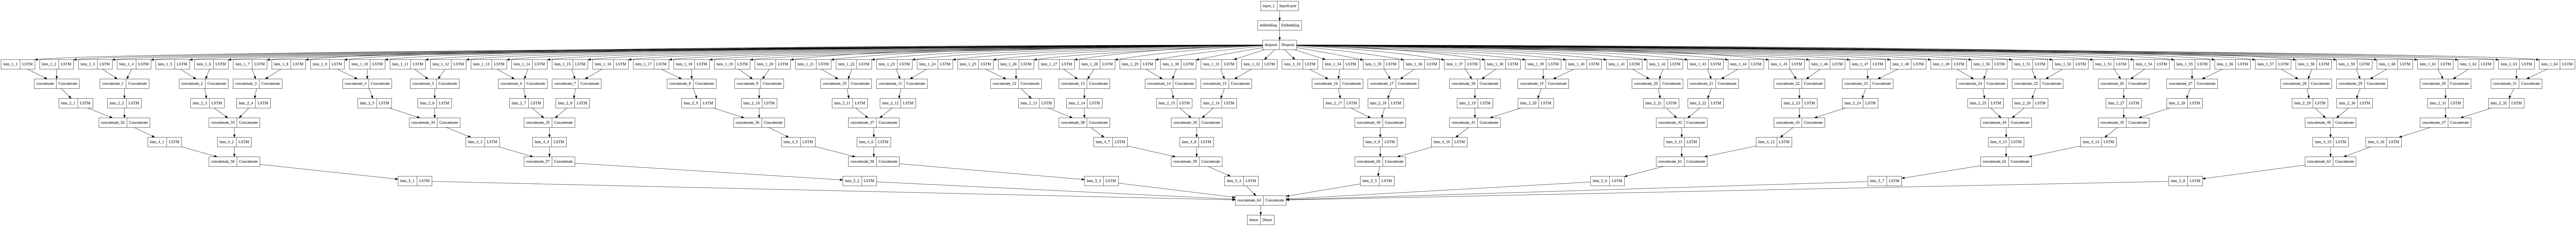

In [62]:
tf.keras.utils.plot_model(pyramid_model)

In [63]:
my_metrics =['accuracy' , 'Precision' , 'Recall'  ]
EPOCHS = 10
BATCH_SIZE = 2048
pyramid_model.compile( loss = bceloss , optimizer = adamoptimizer , metrics = my_metrics )

In [64]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [65]:
half = 2000
validSize = 1000

In [66]:
history3 = pyramid_model.fit(X_train[:half], np.array(Y_train [ :half]),
                    batch_size=BATCH_SIZE,
                    epochs=10,
                    validation_data = (X_validation[: validSize] , np.array(Y_validation [:validSize])),
                    verbose=1,
                    callbacks=callbacks  )

Epoch 1/10
1/1 [==============================] - 275s 275s/step - loss: 0.6922 - accuracy: 0.5295 - precision: 0.5556 - recall: 0.3370 - val_loss: 0.6920 - val_accuracy: 0.5040 - val_precision: 0.5040 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/10
1/1 [==============================] - 5s 5s/step - loss: 0.6942 - accuracy: 0.5045 - precision: 0.5045 - recall: 1.0000 - val_loss: 0.6841 - val_accuracy: 0.6180 - val_precision: 0.6093 - val_recall: 0.6746 - lr: 0.0100
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 0.6856 - accuracy: 0.5965 - precision: 0.5738 - recall: 0.7780 - val_loss: 0.6828 - val_accuracy: 0.6100 - val_precision: 0.8000 - val_recall: 0.3016 - lr: 0.0100
Epoch 4/10
1/1 [==============================] - 5s 5s/step - loss: 0.6847 - accuracy: 0.5805 - precision: 0.6995 - recall: 0.2953 - val_loss: 0.6775 - val_accuracy: 0.6430 - val_precision: 0.7492 - val_recall: 0.4385 - lr: 0.0100
Epoch 5/10
1/1 [==============================] - 5s 5s/step - loss:

In [67]:
pyramid_model.save('pyramid_lstm.h5')

In [68]:
score = pyramid_model.evaluate(x_test, np.array(y_test))
print("ACCURACY:",score[1])
print("LOSS:",score[0])
print("PRECISION:",score[2])
print("RECALL:",score[3])

12/12 [==============================] - 10s 873ms/step - loss: 0.6147 - accuracy: 0.7737 - precision: 0.8731 - recall: 0.6464
ACCURACY: 0.7737430334091187
LOSS: 0.614714503288269
PRECISION: 0.8731343150138855
RECALL: 0.6464088559150696


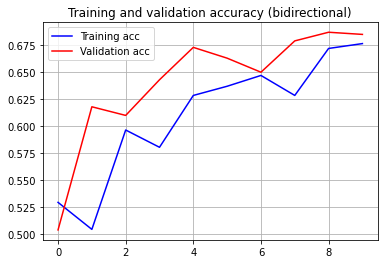

In [71]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
 
epochs = range(len(acc))

plt.figure()

plt.grid() 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (bidirectional)')
plt.legend()
plt.show()


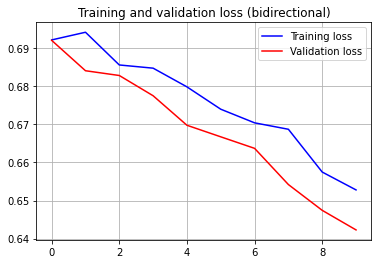

In [72]:
plt.figure()
plt.grid() 

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (bidirectional)')
plt.legend()
plt.show()

12/12 [==============================] - 60s 767ms/step


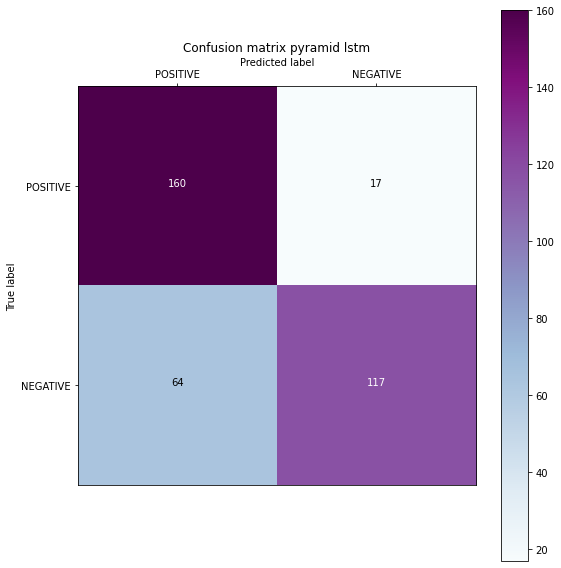

In [73]:
y_pred_p = []
y_test_p = y_test
scores = pyramid_model.predict(x_test, verbose=1).round()
y_pred_p = scores
cnf_matrix = tf.math.confusion_matrix(y_test, y_pred_p)
plot_confusion_matrix(np.array(cnf_matrix), classes= [POSITIVE , NEGATIVE ], title="Confusion matrix pyramid lstm")
plt.show()

In [74]:
c=0
for i in range(len(y_test)):
  if y_pred_p[i] == y_test[i]:
    c+=1
print(c/len(y_test)*100)

77.37430167597765


## pyramid version 2

In [83]:
inputsss = tf.keras.Input( shape = (  SEQUENCE_LENGTH) )
xin_ = Embedding(vocab_size +1,  300 , weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False) ( inputsss)
xin = tf.keras.layers.Dropout(0.5)( xin_)

lstm1 = tf.keras.layers.LSTM (64 , return_sequences = True)(xin)
padding1 = [ [0,0] , [0 , tf.math.floormod(64,2)] , [0,0]]
out1 = tf.pad (lstm1 , padding1)
layer1_out = tf.reshape(out1 , (-1 , 32 , 128))


lstm2 = tf.keras.layers.LSTM (32 , return_sequences = True)(layer1_out)
padding2 = [ [0,0] , [0 , tf.math.floormod(32,2)] , [0,0]]
out2 = tf.pad (lstm2 , padding2)
layer2_out = tf.reshape(out2 , (-1 , 16 , 64))


lstm3 = tf.keras.layers.LSTM (16 , return_sequences = True)(layer2_out)
padding3 = [ [0,0] , [0 , tf.math.floormod(16,2)] , [0,0]]
out3 = tf.pad (lstm3 , padding3)
layer3_out = tf.reshape(out3 , (-1 , 8 , 32))

layer4_out = tf.keras.layers.LSTM (8 )(layer3_out)
out4 = tf.keras.layers.Dense(64 , activation = 'relu') (layer4_out)
out5 = tf.keras.layers.Dense(1 , activation = 'sigmoid') (out4)
pyramid_2 = tf.keras.Model (inputsss , out5 )


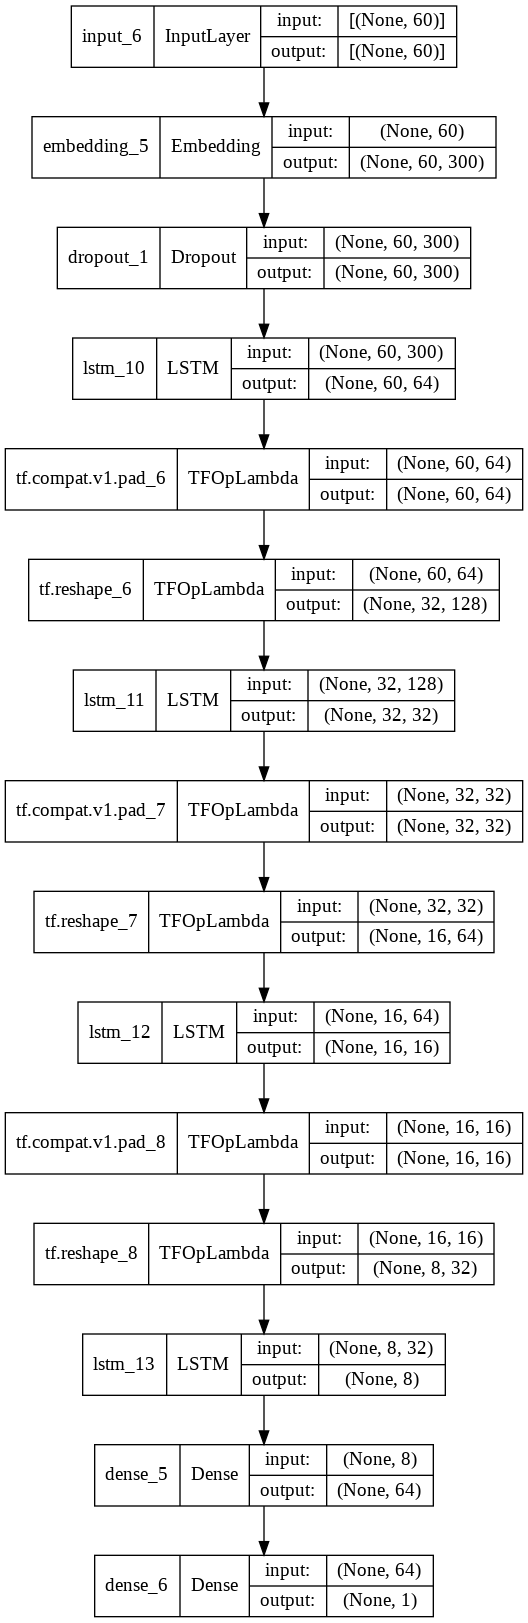

In [84]:
tf.keras.utils.plot_model ( pyramid_2  , show_shapes= True)

In [85]:
embedding_matrix = np.zeros((len(vocabulary)+1 , EMBEDDING_DIM))

In [86]:
for word, idx in vocabulary.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
    else:
        embedding_matrix[idx] = average

In [87]:
adamoptimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
bceloss = tf.keras.losses.binary_crossentropy

In [88]:
my_metrics =['accuracy' , 'Precision' , 'Recall'  ]
EPOCHS = 10
BATCH_SIZE = 2048
pyramid_model.compile( loss = bceloss , optimizer = adamoptimizer , metrics = my_metrics )

In [89]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [91]:
half = len(X_train)
validSize = len(X_validation)

In [ ]:
history3 = pyramid_model.fit(X_train[:half], np.array(Y_train [ :half]),
                    batch_size=BATCH_SIZE,
                    epochs=10,
                    validation_data = (X_validation[: validSize] , np.array(Y_validation [:validSize])),
                    verbose=1,
                    callbacks=callbacks  )

Epoch 1/10


In [ ]:
score = pyramid_model.evaluate(x_test, np.array(y_test))
print("ACCURACY:",score[1])
print("LOSS:",score[0])
print("PRECISION:",score[2])
print("RECALL:",score[3])

12/12 [==============================] - 10s 873ms/step - loss: 0.6147 - accuracy: 0.7737 - precision: 0.8731 - recall: 0.6464
ACCURACY: 0.7737430334091187
LOSS: 0.614714503288269
PRECISION: 0.8731343150138855
RECALL: 0.6464088559150696


In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
 
epochs = range(len(acc))

plt.figure()

plt.grid() 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (bidirectional)')
plt.legend()
plt.show()


In [ ]:
plt.figure()
plt.grid() 

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (bidirectional)')
plt.legend()
plt.show()

12/12 [==============================] - 60s 767ms/step


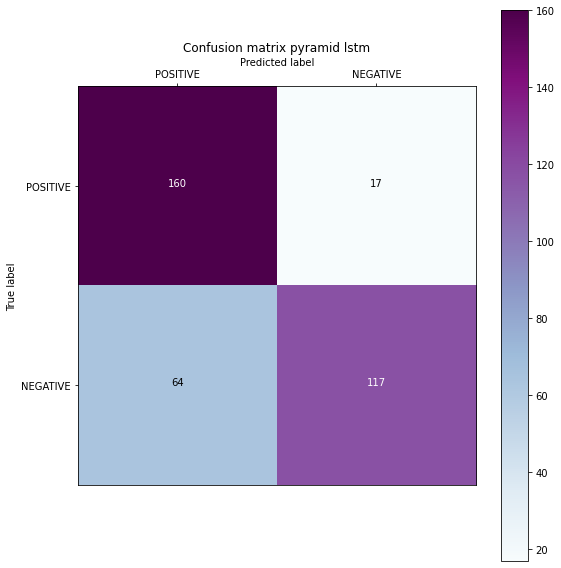

In [ ]:
y_pred_p = []
y_test_p = y_test
scores = pyramid_model.predict(x_test, verbose=1).round()
y_pred_p = scores
cnf_matrix = tf.math.confusion_matrix(y_test, y_pred_p)
plot_confusion_matrix(np.array(cnf_matrix), classes= [POSITIVE , NEGATIVE ], title="Confusion matrix pyramid lstm")
plt.show()

In [ ]:
c=0
for i in range(len(y_test)):
  if y_pred_p[i] == y_test[i]:
    c+=1
print(c/len(y_test)*100)

77.37430167597765
